In [1]:
import numpy as np 
import xarray as xr
import pandas as pd 
import matplotlib.pyplot as plt
import os
import sys
import cartopy.crs as ccrs
%matplotlib inline

from pathlib import Path

sys.path.append('/scistor/ivm/the410/CirculationTrends_Happe2025JCLi/')

from GolfVijf.utils import trendfit_robust, data_for_pcolormesh
from GolfVijf.processing import make_wpd_sst_index, compute_trend_pattern, load_and_subset_data, subdomains

### Determining the trend pattern to get the hotspots
main investigation is in trend_patterns.ipynb

In [2]:
# Hotspot locations
sf_extreme_locs =[(58,-150),(42,-125),(41,-86),(56,-60),(52,-20),(47,3),(52,30),(39.5,65),(45,100),(38,177)] # lat, lon

### Actual loading of rank anoms

In [3]:
var = 'STREAM250'
preprocessing = 'all' #,'seasonality_only' # seasonality_only, all 
startyear = 1940
which_var = f'{var}_midlat_remove_{preprocessing}_{startyear}_onward'


#basedir = Path('/scistor/ivm/jsn295/waveresults/')
basedir = Path('/scistor/ivm/the410/WAVE5/rankday_anomalies/')
ranks = xr.open_dataarray(basedir / f'{which_var}_rank_within_season.nc')
rank_anoms = xr.open_dataarray(basedir / f'{which_var}_rank_day_anomalies.nc')
rank_clim = xr.open_dataarray(basedir / f'{which_var}_rank_day_mean.nc')

In [ ]:
ras = {}
timestamps = {}
for loc in sf_extreme_locs:
    r = ranks.sel(latitude = loc[0], longitude = loc[1], method = 'nearest').to_pandas()
    ra = rank_anoms.sel(latitude = loc[0], longitude = loc[1], method = 'nearest').to_pandas()
    ra.index = pd.MultiIndex.from_arrays([r.index.year,r.values],names = ['year','rank'])
    ts = pd.Series(r.index, index = pd.MultiIndex.from_arrays([r.index.year,r.values],names = ['year','rank']))
    timestamps.update({loc:ts.sort_index()})
    ras.update({loc:ra.sort_index()})
ras = pd.concat(ras, axis = 1)
ras.columns.names = ['latitude','longitude']
timestamps = pd.concat(timestamps, axis = 1)
timestamps.columns.names = ['latitude','longitude']

### Determining thresholds for separating extremes from bulk.

In [ ]:
rankslices = {'deeplow':slice(None, 24, None),
              'bulk':slice(24,70, None),
              'high':slice(70, None, None)}
print(rankslices)
contributions = {}
for name, rankslice in rankslices.items():
    subset = ras.loc[(slice(None),rankslice),:]
    contributions[name] = subset.groupby(subset.index.get_level_values('year')).sum()
contributions = pd.concat(contributions,names = ['rankslices'])

### Determining decadal timescale, creating residuals, visualizing

### Figure 5A 

In [ ]:
decadal_filter = 21 # Years, if 1, then no filtering
yearly = contributions.unstack('rankslices')
decadal = contributions.unstack('rankslices').rolling(decadal_filter, center = True).mean()
residual = yearly - decadal

In [ ]:
fig, axes = plt.subplots(nrows = contributions.shape[-1], sharey = True, figsize = (7,25))
for i, location in enumerate(contributions.columns):
    data = decadal.loc[:,location]
    ax = axes[i]
    ax.stackplot(data.index,data.T, labels=data.columns, colors = ['tab:blue','tab:grey','tab:red'])
    ax.set_title(location) #, color = geoclass[location]['color'])
    ax.legend(loc = (1.1,0))
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows = contributions.shape[-1], sharey = True, figsize = (7,25))
for i, location in enumerate(contributions.columns):
    data = residual.loc[:,location]
    ax = axes[i]
    ax.stackplot(data.index,data.T, labels=data.columns, colors = ['tab:blue','tab:grey','tab:red'])
    ax.set_title(location) #, color = geoclass[location]['color'])
    ax.legend(loc = (1.1,0))
    
plt.tight_layout()

## Correlation matrices, based on decadal and residual series from above

## Figure 5B

In [ ]:
"""
Settings for what you would like to correlate
"""

what = 'high'
assert what in ['local_extreme','deeplow','bulk','high']
startyear = 1950 

if what == 'local_extreme':
    selection = [sf + ('high',) if pos else sf + ('deeplow',) for sf, pos in sf_extreme_positive.items()]
else:
    selection = [sf + (what,) for sf in sf_extreme_locs]
raw_match = yearly.loc[slice(startyear,None),selection].corr()
decadal_match = decadal.loc[slice(startyear,None),selection].corr()
seasonal_match = residual.loc[slice(startyear,None),selection].corr()

#### check with pvals

In [ ]:
def pvals_dataframe(df):
    from scipy.stats import pearsonr
    # adapted from https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
    #create empty dataframe
    pvalues=pd.DataFrame(data=None, columns=df.columns, index=df.columns)

    for r in df.columns:
            for c in df.columns:
                tmp = df[df[r].notnull() & df[c].notnull()]
                pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues
    

force consistent
force consistent
force consistent


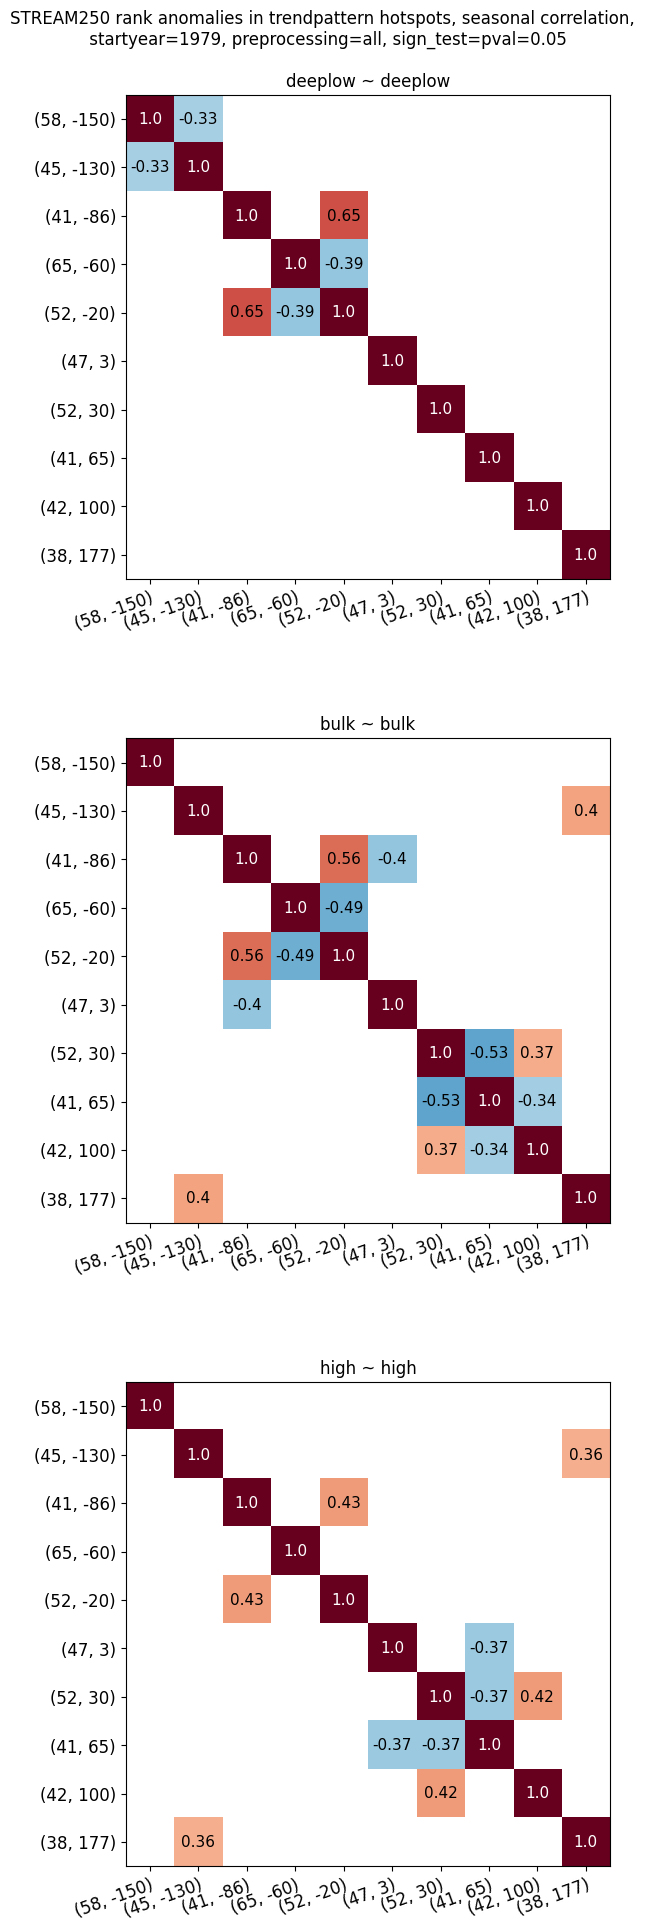

{'deeplow': slice(None, 24, None), 'bulk': slice(24, 70, None), 'high': slice(70, None, None)}


In [16]:
decadal_startyear = 1950 
seasonal_startyear = 1979
which = 'seasonal' #''decadal
PVAL = True 
force_consistent = True 
pval_threshold = 0.05

fig, axes = plt.subplots(nrows = 3, figsize = (6,20)) #, sharex = True)
for i, what in enumerate(['deeplow','bulk','high']):
    selection = [sf + (what,) for sf in sf_extreme_locs]
    data_dec = decadal.loc[slice(decadal_startyear,None),selection].corr()
    data_seas = residual.loc[slice(seasonal_startyear,None),selection].corr()
    if which == 'decadal':
        data = data_dec
        startyear = decadal_startyear
    else:
        data = data_seas
        startyear = seasonal_startyear
    if PVAL:
        if which == 'decadal':
            pvals_df = pvals_dataframe(decadal.loc[slice(decadal_startyear,None),selection])
        elif which == 'seasonal':
            pvals_df = pvals_dataframe(residual.loc[slice(seasonal_startyear,None),selection])
        #here change the significant test to use the pval values    
        significant = (pvals_df.values <= pval_threshold)
        data.loc[:,:] = np.where(significant, data.values, np.nan)
    if force_consistent:
        print("force consistent")
        consistent = np.logical_or((data_dec.values > 0) & (data_seas.values > 0), (data_dec.values < (0)) & (data_seas.values < (0)))
        data.loc[:,:] = np.where(consistent, data.values, np.nan)
        
    data.columns = data.columns.droplevel(-1)
    data.index = data.index.droplevel(-1)
    
    im = axes[i].imshow(data.values, vmin = -1, vmax = 1, cmap = 'RdBu_r') #, aspect = 'auto')
    axes[i].set_xticks(np.arange(data.shape[1]))
    axes[i].set_xticklabels(data.columns.to_flat_index(), size = 12)
    axes[i].set_title(f'{what} ~ {what}')
    axes[i].set_yticks(np.arange(data.shape[0]))
    axes[i].set_yticklabels(data.columns.to_flat_index(), size = 12)

    if i == 0:
        axes[i].set_yticklabels(data.columns.to_flat_index(), size = 12)
    
    plt.setp(axes[i].get_xticklabels(), rotation=20, ha="right",
         rotation_mode="anchor")
    for j, var1 in enumerate(data.index):
        for k, var2 in enumerate(data.columns):
            value = data.loc[var1,var2]
            axes[i].text(k,j,str(np.round(value,2)), 
                 horizontalalignment='center',verticalalignment='center',size = 11, color = 'black' if value < 0.9 else 'white')
if PVAL:
    bt_str = f"pval={pval_threshold}"
elif not PVAL:
    bt_str = "None"
fig.suptitle(f'{var} rank anomalies in trendpattern hotspots, {which} correlation, \n startyear={startyear}, preprocessing={preprocessing}, sign_test={bt_str}')
plt.tight_layout()
plt.show()

print(rankslices)

force consistent
force consistent
force consistent


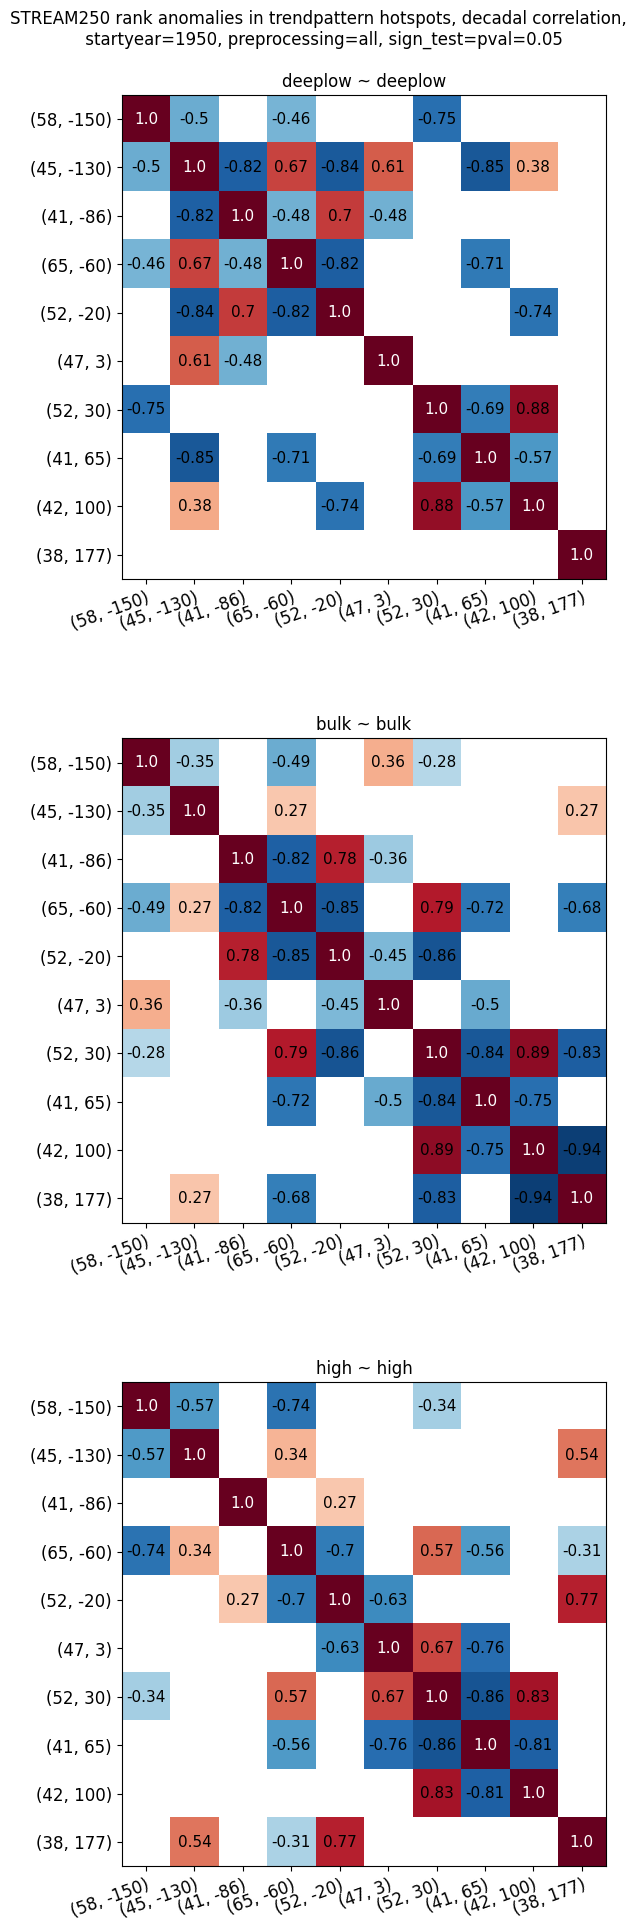

{'deeplow': slice(None, 24, None), 'bulk': slice(24, 70, None), 'high': slice(70, None, None)}


In [13]:
decadal_startyear = 1950 # Can also be important.
seasonal_startyear = 1979
which = 'decadal' #''decadal
PVAL = True # True
force_consistent = True # False 
#bootstrap settings
pval_threshold = 0.05

fig, axes = plt.subplots(nrows = 3, figsize = (6,20)) #, sharex = True)
for i, what in enumerate(['deeplow','bulk','high']):
    selection = [sf + (what,) for sf in sf_extreme_locs]
    data_dec = decadal.loc[slice(decadal_startyear,None),selection].corr()
    data_seas = residual.loc[slice(seasonal_startyear,None),selection].corr()
    if which == 'decadal':
        data = data_dec
        startyear = decadal_startyear
    else:
        data = data_seas
        startyear = seasonal_startyear
    if PVAL:
        if which == 'decadal':
            pvals_df = pvals_dataframe(decadal.loc[slice(decadal_startyear,None),selection])
        elif which == 'seasonal':
            pvals_df = pvals_dataframe(residual.loc[slice(seasonal_startyear,None),selection])
        #here change the significant test to use the pval values    
        significant = (pvals_df.values <= pval_threshold)
        data.loc[:,:] = np.where(significant, data.values, np.nan)
    if force_consistent:
        print("force consistent")
        consistent = np.logical_or((data_dec.values > 0) & (data_seas.values > 0), (data_dec.values < (0)) & (data_seas.values < (0)))
        data.loc[:,:] = np.where(consistent, data.values, np.nan)
        
    data.columns = data.columns.droplevel(-1)
    data.index = data.index.droplevel(-1)
    
    im = axes[i].imshow(data.values, vmin = -1, vmax = 1, cmap = 'RdBu_r') #, aspect = 'auto')
    axes[i].set_xticks(np.arange(data.shape[1]))
    axes[i].set_xticklabels(data.columns.to_flat_index(), size = 12)
    axes[i].set_title(f'{what} ~ {what}')
    axes[i].set_yticks(np.arange(data.shape[0]))
    axes[i].set_yticklabels(data.columns.to_flat_index(), size = 12)

    if i == 0:
        axes[i].set_yticklabels(data.columns.to_flat_index(), size = 12)
    
    plt.setp(axes[i].get_xticklabels(), rotation=20, ha="right",
         rotation_mode="anchor")
    for j, var1 in enumerate(data.index):
        for k, var2 in enumerate(data.columns):
            value = data.loc[var1,var2]
            axes[i].text(k,j,str(np.round(value,2)), 
                 horizontalalignment='center',verticalalignment='center',size = 11, color = 'black' if value < 0.9 else 'white')
if PVAL:
    bt_str = f"pval={pval_threshold}"
elif not PVAL:
    bt_str = "None"
fig.suptitle(f'{var} rank anomalies in trendpattern hotspots, {which} correlation, \n startyear={startyear}, preprocessing={preprocessing}, sign_test={bt_str}')
plt.tight_layout()
plt.show()

print(rankslices)

## Explanation of Rank anomalies - Figure 1 

In [44]:
sf_extreme_locs

[(58, -150),
 (42, -125),
 (41, -86),
 (56, -60),
 (52, -20),
 (47, 3),
 (52, 30),
 (39.5, 65),
 (45, 100),
 (38, 177)]

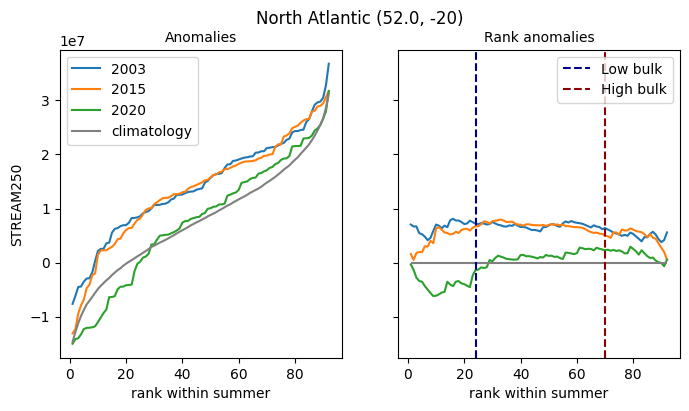

In [39]:
loc, name = 5, 'North Atlantic (52.0, -20)'
years = [2003,2015,2020]
clim = rank_clim.loc[sf_extreme_locs[loc]].to_pandas()
locranoms = ras.loc[years,sf_extreme_locs[loc]]
locanoms = clim + locranoms
locranoms = locranoms.unstack(0)
locanoms = locanoms.unstack(0)

fig, axes = plt.subplots(ncols = 2, sharey = True, figsize = (8,4))
for year in years:
    axes[0].plot(locanoms.index, locanoms[year], label = year)
    axes[1].plot(locranoms.index, locranoms[year])
    if year == years[-1]:
        axes[0].plot(clim.index, clim, color = 'grey', label = 'climatology')
        axes[1].hlines([0], xmin = 1, xmax = 92, color = 'grey')
        axes[0].legend()
fig.suptitle(f'{name}') #', preprocessing = {preprocessing} \n')
axes[0].set_ylabel(f'{var}')
axes[0].set_xlabel('rank within summer')
axes[1].set_xlabel('rank within summer')

axes[1].axvline(x=24, c="darkblue", linestyle="--", label="Low bulk")
axes[1].axvline(x=70, c="darkred", linestyle="--", label="High bulk")
axes[1].legend(loc="upper right")

axes[0].set_title("Anomalies", fontsize=10)
axes[1].set_title("Rank anomalies", fontsize=10)

# fig.tight_layout()
plt.show()